In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
df_cn = pd.read_csv('ConstructionTimeSeriesDataV2.csv')

In [3]:
df = pd.read_csv('ConstructionTimeSeriesDataV2.csv')

# Private Data

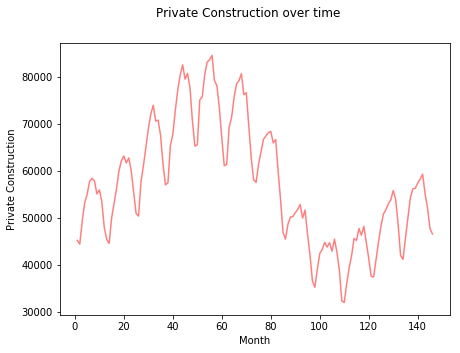

In [4]:
fig, ax = plt.subplots()

ax.plot(df_cn['Month'], df_cn['Private Construction'], alpha=0.5, c = 'r')  
fig.suptitle('Private Construction over time')   # Graph title
ax.xaxis.set_label_text('Month')  # x-axis caption
ax.yaxis.set_label_text('Private Construction')       # y-axis caption
fig.set_size_inches(7,5)
ax.xaxis.set_tick_params(which = 'both', top = False, bottom = True, labelbottom = True) 
ax.yaxis.set_tick_params(which = 'both', right = False, left = True, labelleft = True)
plt.show()

This seems like non linear data, so I will use the non linear approach

Average Squared Error per Month:  37395667.05489795
     Month Month-Year  Total Construction  Private Construction  \
18      19     Jul-03               82971                 62216   
19      20     Aug-03               85191                 63234   
20      21     Sep-03               83841                 61767   
21      22     Oct-03               83133                 62813   
22      23     Nov-03               77915                 60115   
23      24     Dec-03               71050                 55584   
24      25     Jan-04               64934                 50975   
25      26     Feb-04               64138                 50449   
26      27     Mar-04               73238                 57796   
27      28     Apr-04               78354                 61177   
28      29     May-04               83736                 65027   
29      30     Jun-04               89932                 69039   
30      31     Jul-04               93614                 72170   
31      32

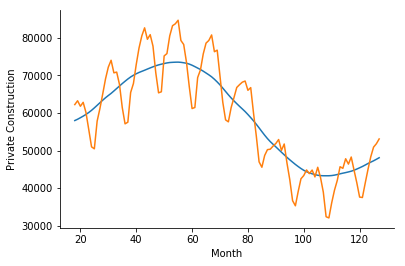

In [5]:
def sqErr(row):
    return (row['homeSales'] - row['MovAvg'])**2
    
df_cn['MovAvg'] = np.NaN
df_cn['sqErr'] = np.NaN

window = 36
window = window - window % 2
for i in range(int(window/2),df_cn.shape[0]-int(window/2)):
    df_cn.loc[df_cn.index[i],'MovAvg'] = (0.5*df_cn.iloc[i - int(window/2)]['Private Construction'] + df_cn.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5*df_cn.iloc[i + int(window/2)]['Private Construction'])/float(window)

df_cn['sqErr'] = (df_cn['Private Construction'] - df_cn['MovAvg'])**2

df_cn.dropna(how='any',inplace=True)

fig,ax = plt.subplots()
ax.plot(df_cn['MovAvg'],label='Moving Avg.')
ax.plot(df_cn['Private Construction'],label='Private Construction')
ax.set_xlabel('Month')
ax.set_ylabel('Private Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Squared Error per Month: ',sum(df_cn['sqErr'])/len(df_cn))
print(df_cn)

In [6]:
df_cn['R1'] = df_cn['Private Construction'] - df_cn['MovAvg']
df_cn['R1Error'] = abs((df_cn['Private Construction'] - df_cn['R1'])/df_cn['Private Construction'])
df_cn.style.format({
    'MovAvg': '{:.1f}'.format,
    'sqErr': '{:,.1f}'.format,
    'R1': '{:,.1f}'.format,
    'R1Error': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,MovAvg,sqErr,R1,R1Error
18,19,Jul-03,82971,62216,20755,57969.4,"18,033,352.0","4,246.6",0.932
19,20,Aug-03,85191,63234,21957,58314.9,"24,197,107.6","4,919.1",0.922
20,21,Sep-03,83841,61767,22075,58718.9,"9,290,896.7","3,048.1",0.951
21,22,Oct-03,83133,62813,20321,59143.6,"13,464,822.5","3,669.4",0.942
22,23,Nov-03,77915,60115,17801,59593.5,"271,918.8",521.5,0.991
23,24,Dec-03,71050,55584,15466,60111.7,"20,500,394.3","-4,527.7",1.081
24,25,Jan-04,64934,50975,13959,60687.3,"94,329,418.8","-9,712.3",1.191
25,26,Feb-04,64138,50449,13689,61335.4,"118,514,067.8","-10,886.4",1.216
26,27,Mar-04,73238,57796,15443,62017.4,"17,820,241.4","-4,221.4",1.073
27,28,Apr-04,78354,61177,17177,62701.1,"2,322,787.7","-1,524.1",1.025


Average Residual:  113.25315656565621


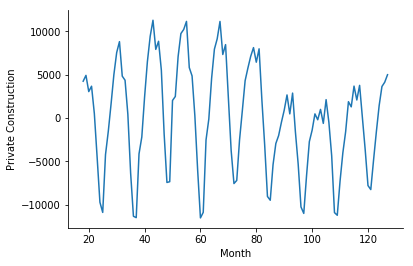

In [7]:
fig,ax = plt.subplots()
ax.plot(df_cn['R1'])
ax.set_xlabel('Month')
ax.set_ylabel('Private Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df_cn['R1'])/len(df_cn))

In [8]:
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = df_cn['R1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8250475036301713
Correlation, lag  2     0.4820939752221447
Correlation, lag  3     0.0661838628463355
Correlation, lag  4     -0.29310582259154694
Correlation, lag  5     -0.5386625150984725
Correlation, lag  6     -0.6496282831082484
Correlation, lag  7     -0.549838477475518
Correlation, lag  8     -0.3185413831731613
Correlation, lag  9     0.02011606382325631
Correlation, lag  10     0.41176952584284515
Correlation, lag  11     0.7322731003955263
Correlation, lag  12     0.8944851710984221
Correlation, lag  13     0.7299213692607464
Correlation, lag  14     0.4055214152186815
Correlation, lag  15     0.0031237974667481893
Correlation, lag  16     -0.34159925855108353
Correlation, lag  17     -0.5745510163732713
Correlation, lag  18     -0.681216824190257
Correlation, lag  19     -0.5902172854543253
Correlation, lag  20     -0.37531995989940625
Correlation, lag  21     -0.04750388422754723
Correlation, lag  22     0.3369494305895757
Correlation, lag  23   

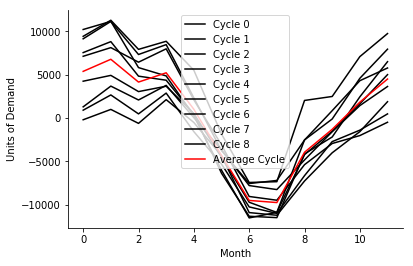

In [9]:
period = 12
cycleLen = period
numCycles = int(len(df_cn)/cycleLen + 0.5)
cycles = [df_cn.iloc[range(i*period,min((i+1)*period,len(df_cn)))]['R1'] for i in range(numCycles)]
ptsInCycles = [df_cn.iloc[range(i,len(df_cn['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='k')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

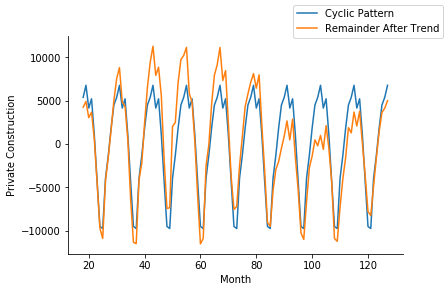

In [10]:
cycleLen = period   # see prior cell for computation of cyclicality period
numCycles = int(len(df_cn)/cycleLen + 0.5)
df_cn['C'] = np.NaN   # Creates an empty column for the cyclicality component data
for i in range(len(df_cn)):
    df_cn.loc[df_cn.index[i], 'C'] = avg[i % cycleLen] # Write appropriate cyclicality value

fig,ax = plt.subplots()
ax.plot(df_cn['C'],label='Cyclic Pattern')
ax.plot(df_cn['R1'],label='Remainder After Trend')
ax.set_xlabel('Month')
ax.set_ylabel('Private Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

In [42]:
df_cn['R2Private'] = df_cn['R1'] - df_cn['C']
df_cn['R2ErrorPrivate'] = abs(df_cn['R2Private']/df_cn['Private Construction'])
df_cn['fit'] = df_cn['MovAvg'] + df_cn['C']
df_cn.drop(['sqErr'],axis=1,inplace=True)
print('Average Error: ', sum(df_cn['R2ErrorPrivate'])/len(df_cn))
print(df_cn)
fig,ax = plt.subplots()
ax.plot(df_cn['Private Construction'],label='Private Construction')
ax.plot(df_cn['fit'], label = 'Fit')
ax.set_xlabel('Month')
ax.set_ylabel('Private Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

KeyError: "['sqErr'] not found in axis"

KeyError: 'R2Private'

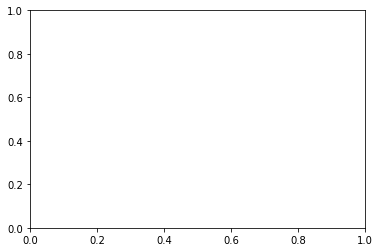

In [40]:
fig,ax = plt.subplots()
ax.plot(df_cn['R2Private'],label='Remainder after Trend and Cyclical Components')
ax.set_xlabel('Month')
ax.set_ylabel('Private Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = df_cn['R2Private'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

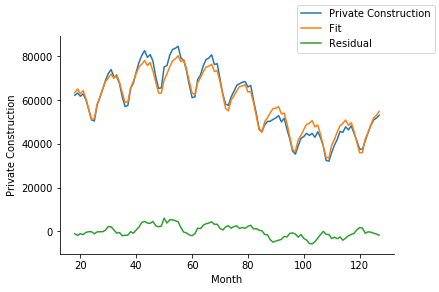

In [13]:
fig,ax = plt.subplots()
ax.plot(df_cn['Private Construction'],label='Private Construction')
ax.plot(df_cn['fit'],label='Fit')
ax.plot(df_cn['R2Private'],label='Residual')
ax.set_xlabel('Month')
ax.set_ylabel('Private Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

In [14]:
for a in [0.1 * i for i in range(1,20)]:
    df_cn['aC'] = a*df_cn['C']
    df_cn['R3'] = df_cn['R1'] - df_cn['aC']
    df_cn['sqErr'] = df_cn['R3']**2
    print('Squared Error for a =','{:.1f}'.format(a),':',sum(df_cn['sqErr']))

Squared Error for a = 0.1 : 3474835029.9367394
Squared Error for a = 0.2 : 2903377036.055973
Squared Error for a = 0.3 : 2399149394.396475
Squared Error for a = 0.4 : 1962152104.958241
Squared Error for a = 0.5 : 1592385167.741274
Squared Error for a = 0.6 : 1289848582.745575
Squared Error for a = 0.7 : 1054542349.9711412
Squared Error for a = 0.8 : 886466469.417975
Squared Error for a = 0.9 : 785620941.0860746
Squared Error for a = 1.0 : 752005764.9754412
Squared Error for a = 1.1 : 785620941.0860747
Squared Error for a = 1.2 : 886466469.417975
Squared Error for a = 1.3 : 1054542349.9711417
Squared Error for a = 1.4 : 1289848582.7455754
Squared Error for a = 1.5 : 1592385167.7412746
Squared Error for a = 1.6 : 1962152104.9582412
Squared Error for a = 1.7 : 2399149394.3964753
Squared Error for a = 1.8 : 2903377036.0559735
Squared Error for a = 1.9 : 3474835029.936742


# Public Data

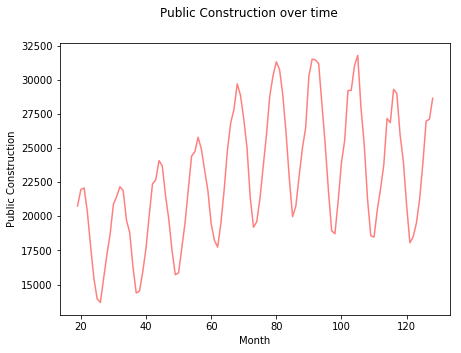

In [15]:
fig, ax = plt.subplots()

ax.plot(df_cn['Month'], df_cn['Public Construction'], alpha=0.5, c = 'r')  
fig.suptitle('Public Construction over time')   # Graph title
ax.xaxis.set_label_text('Month')  # x-axis caption
ax.yaxis.set_label_text('Public Construction')       # y-axis caption
fig.set_size_inches(7,5)
ax.xaxis.set_tick_params(which = 'both', top = False, bottom = True, labelbottom = True) 
ax.yaxis.set_tick_params(which = 'both', right = False, left = True, labelleft = True)
plt.show()

This seems like linear data, so I will use the linear approach

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df['Public Construction'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 18327.939893765724     slope = 52.00857586303297      p_value =  3.028349007007645e-09


In [17]:
def create_regress_col(row, intercept, slope):
    return float(intercept) + float(row['Month']) * slope
    
df['regress'] = df.apply(create_regress_col,args = (intercept,slope),axis = "columns")
df['R1'] = df['Public Construction'] - df['regress']
df.style.format({
    'Public Construction': '{:,.0f}'.format,
    'Total Construction': '{:,.0f}'.format,
    'Private Construction': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,regress,R1
0,1,Jan-02,"59,516","45,273","14,243","18,380","-4,137"
1,2,Feb-02,"58,588","44,475","14,113","18,432","-4,319"
2,3,Mar-02,"63,782","49,396","14,386","18,484","-4,098"
3,4,Apr-02,"69,504","53,283","16,221","18,536","-2,315"
4,5,May-02,"73,384","55,009","18,375","18,588",-213
5,6,Jun-02,"77,182","57,801","19,381","18,640",741
6,7,Jul-02,"78,863","58,494","20,369","18,692","1,677"
7,8,Aug-02,"79,460","57,953","21,507","18,744","2,763"
8,9,Sep-02,"76,542","55,157","21,385","18,796","2,589"
9,10,Oct-02,"75,710","56,023","19,687","18,848",839


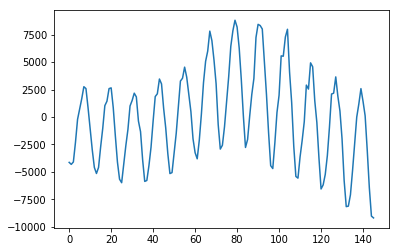

In [18]:
plt.plot(df.index,df.R1)

C:\Users\alexf\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


   Month Month-Year  Total Construction  Private Construction  \
0      1     Jan-02               59516                 45273   
1      2     Feb-02               58588                 44475   
2      3     Mar-02               63782                 49396   
3      4     Apr-02               69504                 53283   
4      5     May-02               73384                 55009   
5      6     Jun-02               77182                 57801   
6      7     Jul-02               78863                 58494   
7      8     Aug-02               79460                 57953   
8      9     Sep-02               76542                 55157   
9     10     Oct-02               75710                 56023   

   Public Construction       regress           R1  lag12  
0                14243  18379.948470 -4136.948470    NaN  
1                14113  18431.957045 -4318.957045    NaN  
2                14386  18483.965621 -4097.965621    NaN  
3                16221  18535.974197 -2314.97419

Text(0.5, 0, 'Month')

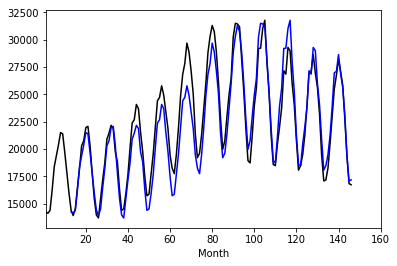

In [19]:
lag = 12
df['lag12'] = np.NaN
for i in range(len(df['lag12']))[lag:]:
    df['lag12'].iloc[i] = df['Public Construction'].iloc[i-12]
print(df.head(n=10))

for i in range(int(len(df.index)/2)):
    print('autocorrelation, lag =',i,':',df.R1.autocorr(lag = i))
    
fig,ax = plt.subplots()
ax.plot(df.Month,df['Public Construction'],c='k')
ax.plot(df.Month,df.lag12,c='b')
ax.set_xlim([1,160])
ax.set_xlabel('Month')

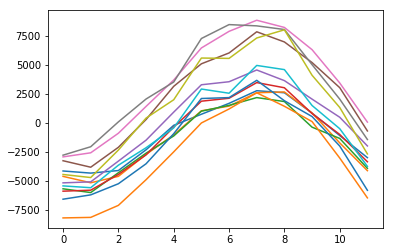

In [20]:
dfMon = pd.DataFrame()
cycleLen = 12
for i in range(int(len(df.index)/cycleLen)):
    newData = pd.DataFrame({i:df['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfMon = pd.concat([dfMon,newData],axis=1)

fig,ax = plt.subplots()
ax.plot(dfMon)

              0            1            2            3            4  \
0  -4136.948470 -4600.051380 -5669.154290 -5872.257201 -5157.360111   
1  -4318.957045 -5150.059956 -5991.162866 -5787.265777 -5071.368687   
2  -4097.965621 -4598.068532 -4289.171442 -4436.274352 -3288.377263   
3  -2314.974197 -2716.077108 -2607.180018 -2752.282928 -1488.385839   
4   -212.982773 -1025.085683 -1127.188594  -363.291504   922.605585   
5    741.008651  1036.905741  1004.802830  1862.699920  3274.597010   
6   1677.000075  1438.897165  1503.794254  2114.691344  3534.588434   
7   2762.991499  2588.888589  2171.785679  3461.682768  4544.579858   
8   2588.982923  2654.880013  1831.777103  3016.674192  3630.571282   
9    838.974348   848.871437  -370.231473   798.665617  2039.562706   
10 -1090.034228 -1723.137139 -1339.240049  -997.342959   481.554130   
11 -2991.042804 -4110.145714 -3905.248625 -3345.351535 -1984.454446   

              5            6            7            8            9  \
0  -3

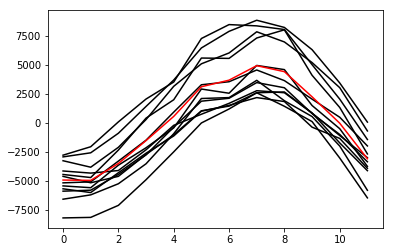

In [21]:
avg = []
for i in range(len(dfMon.index)):
    avg.append(dfMon.iloc[i].mean())

dfMon = pd.concat([dfMon,pd.DataFrame({'avg':avg})], axis=1)
print(dfMon)

fig,ax = plt.subplots()
c = 180
for col in dfMon.columns.values:
    if col == 'avg':
        ax.plot(dfMon[col], c = 'r')
    else:
        ax.plot(dfMon[col], c = 'k')

In [37]:
df['S'] = np.NaN
df['R2Public'] = np.NaN
df['Composite'] = np.NaN
df['R2ErrorPublic'] = np.NaN
S = dfMon['avg'].tolist()
for i in df.index:
    df.loc[i,'S'] = S[i%cycleLen]
    df.loc[i,'R2Public'] = df.loc[i,'R1'] - df.loc[i,'S']
    df.loc[i,'Composite'] = df.loc[i,'regress'] + df.loc[i,'S']
    df.loc[i,'R2ErrorPublic'] = 100*df.loc[i,'R2Public'] / df.loc[i,'Public Construction']
df.style.format({
    'Public Construction': '{:,.0f}'.format,
    'Private Construction': '{:,.0f}'.format,
    'Total Construction': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format,
    'S': '{:,.0f}'.format,
    'R2Public': '{:,.0f}'.format,
    'Composite':'{:,.0f}'.format,
    'R2ErrorPublic': '{:.2f}%'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,regress,R1,lag12,S,R2Private,Composite,R2ErrorPrivate,R2,R2Public,R2ErrorPublic
0,1,Jan-02,"59,516","45,273","14,243","18,380","-4,137",nan,"-4,915",778.316,"13,465",5.46455,778.316,778,5.46%
1,2,Feb-02,"58,588","44,475","14,113","18,432","-4,319",nan,"-4,946",626.816,"13,486",4.44141,626.816,627,4.44%
2,3,Mar-02,"63,782","49,396","14,386","18,484","-4,098",nan,"-3,494",-604.184,"14,990",-4.19981,-604.184,-604,-4.20%
3,4,Apr-02,"69,504","53,283","16,221","18,536","-2,315",nan,"-1,523",-792.267,"17,013",-4.88421,-792.267,-792,-4.88%
4,5,May-02,"73,384","55,009","18,375","18,588",-213,nan,555,-767.684,"19,143",-4.17787,-767.684,-768,-4.18%
5,6,Jun-02,"77,182","57,801","19,381","18,640",741,nan,"3,104",-2362.93,"21,744",-12.192,-2362.93,"-2,363",-12.19%
6,7,Jul-02,"78,863","58,494","20,369","18,692","1,677",nan,"3,670",-1993.02,"22,362",-9.78456,-1993.02,"-1,993",-9.78%
7,8,Aug-02,"79,460","57,953","21,507","18,744","2,763",nan,"4,916",-2152.68,"23,660",-10.0092,-2152.68,"-2,153",-10.01%
8,9,Sep-02,"76,542","55,157","21,385","18,796","2,589",nan,"4,400",-1811.27,"23,196",-8.4698,-1811.27,"-1,811",-8.47%
9,10,Oct-02,"75,710","56,023","19,687","18,848",839,nan,"2,239",-1400.02,"21,087",-7.11138,-1400.02,"-1,400",-7.11%


Text(0, 0.5, 'Demand/Sales')

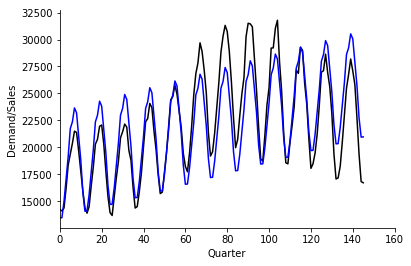

In [23]:
fig, ax = plt.subplots()
ax.plot(df['Public Construction'],c='k')
ax.plot(df['Composite'],c='b')
ax.set_xlim([0,160])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Quarter')
ax.set_ylabel('Demand/Sales')

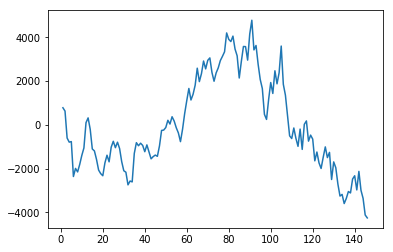

In [38]:
plt.plot(df.Month,df.R2Public)

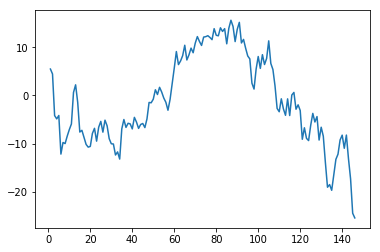

In [39]:
plt.plot(df.Month,df.R2ErrorPublic)